Here, we create a condensed visualization for some of the results across Notebook 3 and 4:

In [216]:
import os

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [217]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'


In [218]:
stats_all = pd.read_csv(os.path.join(data_path, 'interim', 'proteomics_consensus_comparison_statistics.csv'), 
                       index_col = 0)
stats_all['Modality'] = 'Proteomics'
stats_all['Feature Intersection'] = False

stats_all_intersection = pd.read_csv(os.path.join(data_path, 'interim', 'proteomics_consensus_comparison_intersection.csv'), 
                       index_col = 0)
stats_all_intersection.metric = stats_all_intersection.metric.replace('MSE', 'Mean Squared Error')
stats_all_intersection.rename(columns = {'cohend': 'cohen_d'}, inplace = True)
stats_all_intersection.insert(3, 'fdr', stats_all_intersection.pval)
stats_all_intersection['Modality'] = 'Proteomics'
stats_all_intersection['Feature Intersection'] = True

stats_all_proteomics = pd.concat([stats_all, stats_all_intersection])

stats_all = pd.read_csv(os.path.join(data_path, 'interim', 'joint_consensus_comparison_statistics.csv'), 
                       index_col = 0)
stats_all['Modality'] = 'Joint'
stats_all['Feature Intersection'] = False

stats_all = pd.concat([stats_all_proteomics, stats_all], axis = 0)
stats_all.reset_index(drop = True, inplace = True)

In [219]:
# formatting
stats_all.comparison = stats_all.comparison.apply(lambda x: eval(x)[1])

fi = stats_all[stats_all['Feature Intersection']].index.tolist()
stats_all.loc[fi, 'comparison'] = stats_all.loc[fi, 'comparison'].astype(str) + '\n(Feature Intersection)'


stats_all.Modality = pd.Categorical(stats_all.Modality, ordered = True, categories = ['Proteomics', 'Joint'])
# stats_all['Feature Intersection'] = pd.Categorical(stats_all['Feature Intersection'], 
#                                                    ordered = True, categories = [False, True])

stats_all.comparison = pd.Categorical(stats_all.comparison, 
                                     ordered = True, 
                                     categories = ['Linear SVR', 'Linear SVR\n(Feature Intersection)',
                                                   'Polynomial SVR', 'RBF SVR', 'Ridge'])
stats_all = stats_all.sort_values(by = ['Modality', 'comparison'])

stats_all.metric = pd.Categorical(stats_all.metric, ordered = True, categories = ['Pearson Correlation', 
                                                                                  'Mean Squared Error'])

stats_all['pval_style'] = False
sig = stats_all[stats_all.fdr <= 0.1].index.tolist()
stats_all.loc[sig, 'pval_style'] = True
stats_all.pval_style = pd.Categorical(stats_all.pval_style, 
                                                   ordered = True, categories = [True, False])

In [222]:
stats_all[(stats_all.Modality == 'Proteomics') & (stats_all.metric == 'Mean Squared Error')]

,comparison,pval,cohen_d,fdr,metric,Modality,Feature Intersection,pval_style
5,Linear SVR,0.000608,-1.758480,0.002432,Mean Squared Error,Proteomics,False,True
9,Linear SVR\n(Feature Intersection),0.088973,-0.436855,0.088973,Mean Squared Error,Proteomics,True,True
6,Polynomial SVR,0.062694,-0.909504,0.062694,Mean Squared Error,Proteomics,False,True
7,RBF SVR,0.028974,-1.006517,0.038632,Mean Squared Error,Proteomics,False,True
4,Ridge,0.014473,-1.107478,0.028945,Mean Squared Error,Proteomics,False,True


In [212]:
stats_all = stats_all[~stats_all['Feature Intersection']]


/tmp/ipykernel_1203308/2895946916.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')
/tmp/ipykernel_1203308/2895946916.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(labels, rotation=45, ha='right')


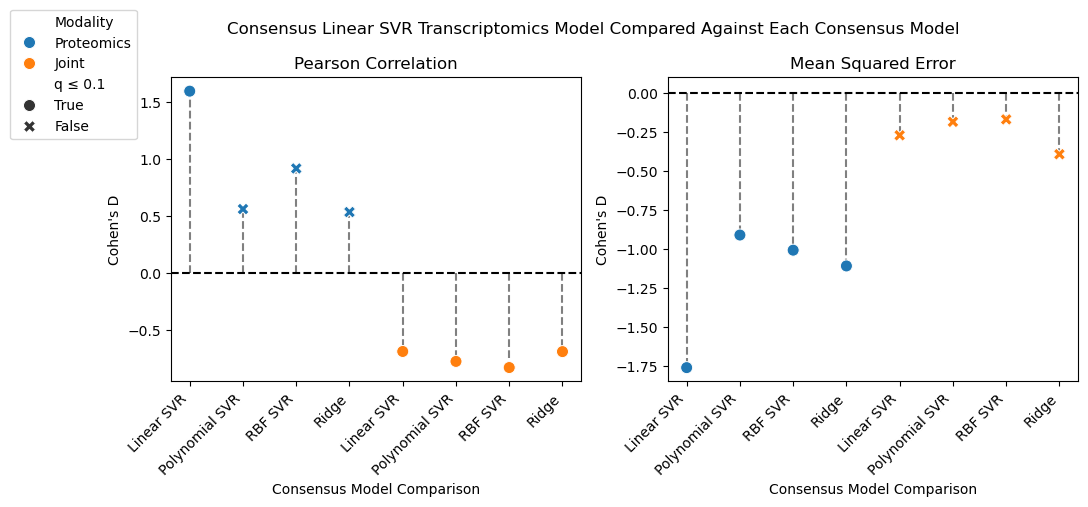

In [213]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

for i, metric in enumerate(stats_all.metric.cat.categories):
    viz_df = stats_all[stats_all.metric == metric].copy()
    viz_df['x_axis'] = viz_df.comparison.astype(str) + '^' + viz_df.Modality.astype(str)

    sns.scatterplot(data=viz_df, x='x_axis', y='cohen_d', style='pval_style',
                    hue='Modality', ax=ax[i], legend=(i == 0), s = 75)
    ax[i].axhline(0, linestyle='--', color='black')
    for _, row in viz_df.iterrows():
        ax[i].plot([row['x_axis'], row['x_axis']], [0, row['cohen_d']], linestyle='--', color='gray', 
                  zorder = 0)


    ax[i].set_ylabel("Cohen's D")
    ax[i].set_title(metric)
    ax[i].set_xlabel('Consensus Model Comparison')

    labels = [tick.get_text().split('^')[0] for tick in ax[i].get_xticklabels()]
    ax[i].set_xticklabels(labels, rotation=45, ha='right')

    ylim = ax[i].get_ylim()
    ymax = 0.1
    if ylim[1] < ymax:
        ax[i].set_ylim(ylim[0], ymax)

# Move legend from ax[0] to figure
handles, labels = ax[0].get_legend_handles_labels()
labels = ['q ≤ 0.1' if lbl == 'pval_style' else lbl for lbl in labels]
ax[0].legend_.remove()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(-0.09, 0.875))
fig.suptitle('Consensus Linear SVR Transcriptomics Model Compared Against Each Consensus Model')

fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'all_comparisons_lollipop.png'), 
            dpi=300, 
            bbox_inches="tight")  

In [215]:
stats_all[stats_all.Modality == 'Porteomics']

,comparison,pval,cohen_d,fdr,metric,Modality,Feature Intersection,pval_style
